# _(Wong & Wang, 2006)_ Decision model

Implementation of the paper:

- [1] Wong, K.-F. & Wang, X.-J. A Recurrent Network Mechanism 
  of Time Integration in Perceptual Decisions. 
  J. Neurosci. 26, 1314–1328 (2006).
  
We adopt a simplified version from: 

- [2] Stanford University, BIOE 332: Large-Scale Neural Modeling, 
    Kwabena Boahen & Tatiana Engel, 2013, online available.

In [1]:
import brainpy as bp
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

We use the model from Ref. [2], which is derived from the simplest form (without AMPA at recurrent synapses) of the original paper (Ref. [1]) :

$$ \frac {dS_i}{dt} = - \frac{S_i}{\tau_S} + (1-S_i)\gamma f(I_{{\rm syn}, i}) $$

$$ f(x_i) = \frac {a I_{{\rm syn}, i} - b}{1-{\rm exp} [-d(aI_{{\rm syn}, i} - b)]} $$

$$ I_{{\rm syn}, 1} = J_{11} S_1 - J_{12} S_2 +I_0 + I_1 $$

$$ I_{{\rm syn}, 2} = J_{22} S_2 - J_{21} S_1 +I_0 + I_2 $$

$$ I_i = J_{\rm A, ext} \mu_0 (1 +- c') $$


where $i=1,2$ labels the selective population. 

Parameter values for the input-output function $H_i$ are $a = 270$(VnC)$^{-1}, b = 108$Hz, and $d = 0.154$s.

The kinetic parameters are $\gamma = 0.641, \tau_s = 60$ms.

$J_{ij}$ represents the effective network connectivity from j to i, and we will use $J_{11} = J_{22} = 0.3725$ nA, $J_{12} = J_{21} = 0.1137$nA, and $J_{\rm A, ext} = 5.2 \times 10^{-4}$nA$\cdot$Hz$^{-1}$.

The overall effective external inputs is $I_0 = 0.3297$nA.

In [2]:
# simplified version from lab2, without noise
def decision_model(tau_s=.06, gamma=0.641,
                J_rec = .3725, J_inh = .1137, 
                I_0=.3297,
                a = 270., b=108., d=0.154):

    ST = bp.types.NeuState('r1', 'r2','I1','I2', s1=0.06, s2=0.06)
    
    @bp.integrate
    def int_s1(s1, t, s2, I1): 
        I_syn = J_rec * s1 - J_inh * s2 + I_0 + I1
        r1 = (a * I_syn - b) / (1. - np.exp(-d * (a * I_syn - b)))
        dsdt = - s1 / tau_s + (1. - s1) * gamma * r1
        return (dsdt,), r1

    @bp.integrate
    def int_s2(s2, t, s1, I2):
        I_syn = J_rec * s2 - J_inh * s1 + I_0 + I2
        r2 = (a * I_syn - b) / (1. - np.exp(-d * (a * I_syn - b)))
        dsdt = - s2 / tau_s + (1. - s2) * gamma * r2
        return (dsdt,), r2

    def update(ST, _t):
        s1, ST['r1'] = int_s1(ST['s1'], _t, ST['s2'],ST['I1'])
        s2, ST['r2'] = int_s2(ST['s2'], _t, ST['s1'],ST['I2'])
        ST['s1'] = s1
        ST['s2'] = s2
        ST['I1'], ST['I2'] = 0, 0

    return bp.NeuType(name='neuron', 
                    ST=ST, 
                    steps=update, 
                    mode='scalar')

In [3]:
def get_stimulus(coh, mu0=30., JAext=.00117):
    I1 = JAext * mu0 * (1 + coh) 
    I2 = JAext * mu0 * (1 - coh) 
    return I1, I2

## Phase plane analysis

We will replicate Fig. 5 from Ref. [1].

**No stimulus**

Fixed point #1 at s2=0.06176109215560733, s1=0.061761097890810475 is a stable-node.
Fixed point #2 at s2=0.029354239100062428, s1=0.18815448592736211 is a saddle-node.
Fixed point #3 at s2=0.0042468423702408655, s1=0.6303045696241589 is a stable-node.
Fixed point #4 at s2=0.6303045696241589, s1=0.004246842370235128 is a stable-node.
Fixed point #5 at s2=0.18815439944520335, s1=0.029354240536530615 is a saddle-node.


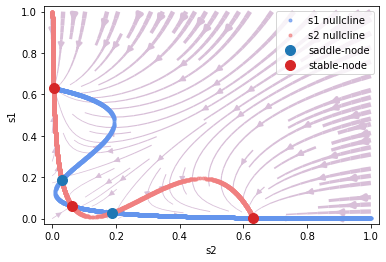

(array([0.06176109, 0.02935424, 0.00424684, 0.63030457, 0.1881544 ]),
 array([0.0617611 , 0.18815449, 0.63030457, 0.00424684, 0.02935424]))

In [4]:
I1=0.
I2=0.

analyzer = bp.analysis.PhasePlane(
    model=decision_model(),
    target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
    fixed_vars={'I1': I1, 'I2':I2},
    numerical_resolution=0.0005,
    options={'escape_sympy_solver': True}
)

analyzer.plot_vector_field()
analyzer.plot_nullcline(numerical_setting={
                        'int_s1':dict(coords='s1-s2'), 
                        'int_s2':dict(coords='s2-s1')})
analyzer.plot_fixed_point(show=True)

**Symmetric stimulus (0% coherence)**

0.0351 0.0351
Fixed point #1 at s2=0.6993504413888704, s1=0.011622049527244513 is a stable-node.
Fixed point #2 at s2=0.49867489858358865, s1=0.49867489858358865 is a saddle-node.
Fixed point #3 at s2=0.011622051540013747, s1=0.6993504355529327 is a stable-node.


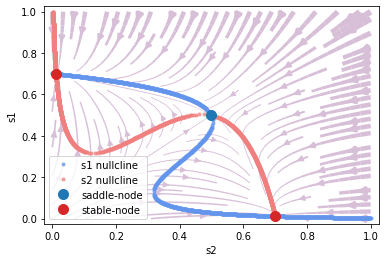

(array([0.69935044, 0.4986749 , 0.01162205]),
 array([0.01162205, 0.4986749 , 0.69935044]))

In [5]:
I1, I2 = get_stimulus(coh=0.)
print(I1, I2)

analyzer = bp.analysis.PhasePlane(
    model=decision_model(),
    target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
    fixed_vars={'I1': I1, 'I2':I2},
    numerical_resolution=0.001,
    options={'escape_sympy_solver': True}
)

analyzer.plot_vector_field()
analyzer.plot_nullcline(numerical_setting={
                        'int_s1':dict(coords='s1-s2'), 
                        'int_s2':dict(coords='s2-s1')})
analyzer.plot_fixed_point(show=True)

**Biased stimulus (14% coherence)**

0.040014 0.030185999999999998
Fixed point #1 at s2=0.009368536785257226, s1=0.706534542997363 is a stable-node.
Fixed point #2 at s2=0.6914853214021102, s1=0.014516767247977323 is a stable-node.
Fixed point #3 at s2=0.5408174270167093, s1=0.43078964580182816 is a saddle-node.


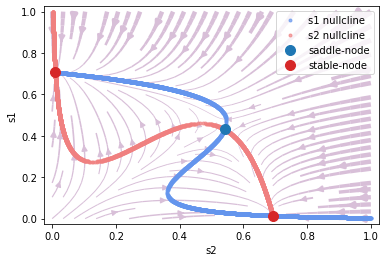

(array([0.00936854, 0.69148532, 0.54081743]),
 array([0.70653454, 0.01451677, 0.43078965]))

In [6]:
I1, I2 = get_stimulus(coh=.14)
print(I1, I2)

analyzer = bp.analysis.PhasePlane(
    model=decision_model(),
    target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
    fixed_vars={'I1': I1, 'I2':I2},
    numerical_resolution=0.0005,
    options={'escape_sympy_solver': True}
)

analyzer.plot_vector_field()
analyzer.plot_nullcline(numerical_setting={
                        'int_s1':dict(coords='s1-s2'), 
                        'int_s2':dict(coords='s2-s1')})
analyzer.plot_fixed_point(show=True)

**Biased stimulus (51.2% coherence)**

0.0530712 0.0171288
Fixed point #1 at s2=0.5673124813731691, s1=0.2864701069327971 is a saddle-node.
Fixed point #2 at s2=0.6655747347157656, s1=0.027835279565912054 is a stable-node.
Fixed point #3 at s2=0.005397687847426814, s1=0.7231453520305031 is a stable-node.


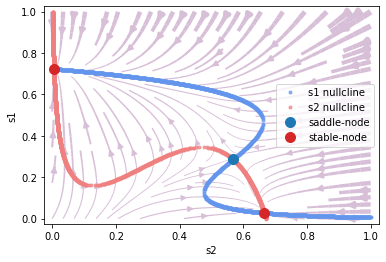

(array([0.56731248, 0.66557473, 0.00539769]),
 array([0.28647011, 0.02783528, 0.72314535]))

In [7]:
I1, I2 = get_stimulus(coh=.512)
print(I1, I2)

analyzer = bp.analysis.PhasePlane(
    model=decision_model(),
    target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
    fixed_vars={'I1': I1, 'I2':I2},
    numerical_resolution=0.001,
    options={'escape_sympy_solver': True}
)

analyzer.plot_vector_field()
analyzer.plot_nullcline(numerical_setting={
                        'int_s1':dict(coords='s1-s2'), 
                        'int_s2':dict(coords='s2-s1')})
analyzer.plot_fixed_point(show=True)

**Stimulus to one population only (100% coherence)**

0.0702 0.0
Fixed point #1 at s2=0.0026865954387078755, s1=0.7410985604497689 is a stable-node.


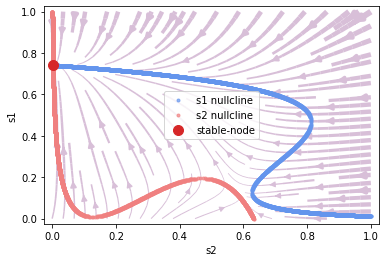

(array([0.0026866]), array([0.74109856]))

In [8]:
I1, I2 = get_stimulus(coh=1.)
print(I1, I2)

analyzer = bp.analysis.PhasePlane(
    model=decision_model(),
    target_vars=OrderedDict(s2=[0., 1.], s1=[0., 1.]),
    fixed_vars={'I1': I1, 'I2':I2},
    numerical_resolution=0.0005,
    options={'escape_sympy_solver': True}
)

analyzer.plot_vector_field()
analyzer.plot_nullcline(numerical_setting={'int_s1':dict(coords='s1-s2'), 
                                           'int_s2':dict(coords='s2-s1')})
analyzer.plot_fixed_point(show=True)